In [2]:
import numpy as np
import gstools as gs
import matplotlib.pyplot as plt
%matplotlib inline
from dataset import *
from save_load import *
from NN_library.MN.material_NN import *
from NN_library.MN.train_MNN import *
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
data = dataset_grid(129, [0, 2*np.pi], [0, 2*np.pi])
loaders = get_loaders_Sobol(data, 129**2)

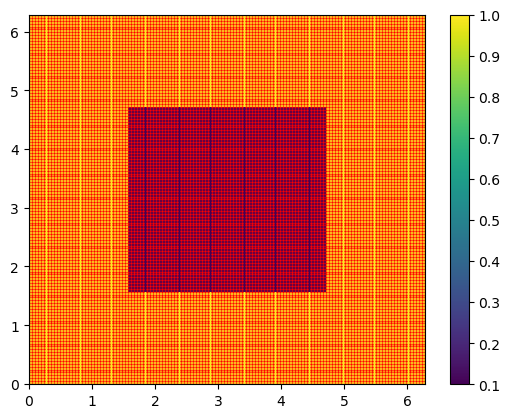

In [14]:
L = 2*np.pi
N = 512 # number of nodes in each direction including the border
x = np.linspace(0, L, N, endpoint=True)
y = np.linspace(0, L, N, endpoint=True)

XY = np.meshgrid(x, y)
grid_data = torch.tensor(np.vstack((XY[0].flatten(), XY[1].flatten())).T, dtype=torch.float, device=dev)

def a_function(x,y):
    a = np.where((x>np.pi/2)&(x<3*np.pi/2)&(y>np.pi/2)&(y<3*np.pi/2), 0.1, 1)
    return a

def A(x):
    a = torch.where((x[:,0]>torch.pi/2)&(x[:,0]<3*torch.pi/2)&(x[:,1]>torch.pi/2)&(x[:,1]<3*torch.pi/2), 0.1, 1)
    return a.view(-1,1)

Z = a_function(XY[0].flatten(),XY[1].flatten())
plt.pcolormesh(XY[0], XY[1], Z.reshape(N, N))
plt.colorbar()
plt.scatter(data[:,0], data[:,1], s = 0.5, c='r')

In [12]:
net = Material_NN()
total_params = sum(p.numel() for p in net.parameters())
print(f"Number of parameters: {total_params}")
args = {'lr' : 0.001, 'epochs' : 30000, 'dev' : dev, 'name' : f'NN_library/MN/MN_{total_params}'}

Number of parameters: 16


In [6]:
net = load_network(net, args['name']+'_29999', args)
net = net.to(dev)

In [15]:
losses_train = train(net, loaders, args, A)

Epoch: 99 mean train loss:  4.32229022e-05
Epoch: 199 mean train loss:  3.65319414e-05
Epoch: 299 mean train loss:  3.08185277e-05
Epoch: 399 mean train loss:  2.73866329e-05
Epoch: 499 mean train loss:  2.53168015e-05
Epoch: 599 mean train loss:  2.35836965e-05
Epoch: 699 mean train loss:  2.17439918e-05
Epoch: 799 mean train loss:  1.97882191e-05
Epoch: 899 mean train loss:  1.79104436e-05
Epoch: 999 mean train loss:  1.63313163e-05
Epoch: 1099 mean train loss:  1.51434338e-05
Epoch: 1199 mean train loss:  1.42926940e-05
Epoch: 1299 mean train loss:  1.36667440e-05
Epoch: 1399 mean train loss:  1.31734261e-05
Epoch: 1499 mean train loss:  1.27607058e-05
Epoch: 1599 mean train loss:  1.24030842e-05
Epoch: 1699 mean train loss:  1.20870571e-05
Epoch: 1799 mean train loss:  1.18041374e-05
Epoch: 1899 mean train loss:  1.15483274e-05
Epoch: 1999 mean train loss:  1.13151606e-05
Epoch: 2099 mean train loss:  1.11012236e-05
Epoch: 2199 mean train loss:  1.09038631e-05
Epoch: 2299 mean trai

In [17]:
np.save(f'NN_library/training_data/MN_{total_params}', losses_train)

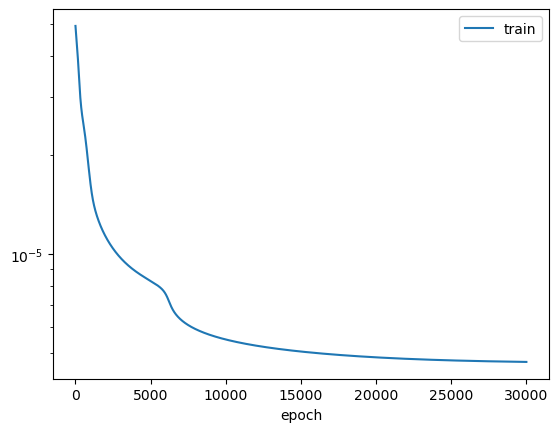

In [16]:
plt.plot(losses_train)
plt.xlabel('epoch')
plt.legend(['train'])
plt.yscale('log')

In [18]:
a_numpy = a_function(XY[0].flatten(), XY[1].flatten())
a_torch = torch.tensor(a_numpy, device=dev, dtype=torch.float).view(-1,1)
mat_err = net(grid_data).detach().cpu() - A(grid_data).detach().cpu()

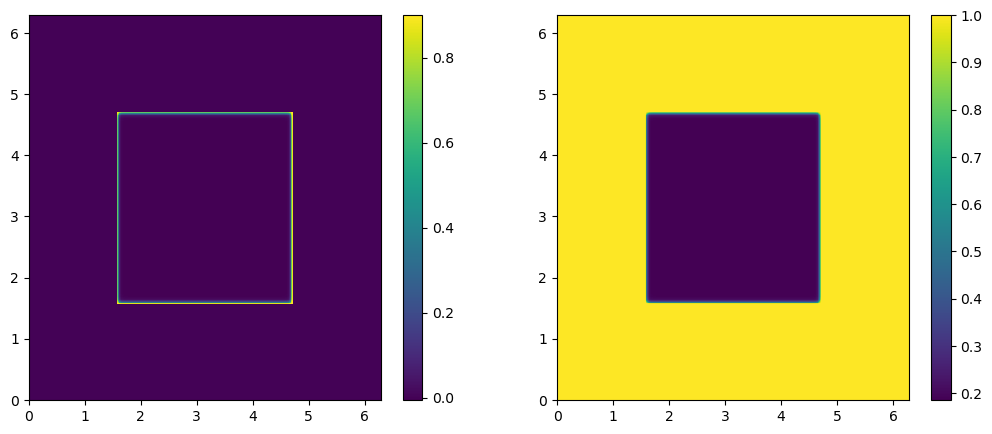

In [22]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12.5,5))
pos1 = axs[0].pcolormesh(XY[0], XY[1], mat_err.reshape(N, N))
fig.colorbar(pos1)
pos2 = axs[1].pcolormesh(XY[0], XY[1], 0.1 + 0.9*net(grid_data).detach().cpu().reshape(N, N))
fig.colorbar(pos2)